In [ ]:
# packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import scipy.stats as stats
from typing import List, Dict, Any, Union
from itertools import product
import networkx as nx

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TODO: This MIGHT be different for yall, so just pay attention to this.
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "576_Project/data"
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

# Should just see Wellbeing_and_lifestyle_data_Kaggle.csv here
print(os.listdir(GOOGLE_DRIVE_PATH))

assert 'Wellbeing_and_lifestyle_data_Kaggle.csv' in list(os.listdir(GOOGLE_DRIVE_PATH)), "Data not found, check your file paths!"

full_data_path = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE, "Wellbeing_and_lifestyle_data_Kaggle.csv")
df = pd.read_csv(full_data_path)
print(df.head())

['Wellbeing_and_lifestyle_data_Kaggle.csv']
  Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15               3            2               2            5   
1    7/7/15               2            3               4            3   
2    7/7/15               2            3               3            4   
3    7/7/15               3            3              10            3   
4    7/7/15               5            1               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                  0               5            2         0          1  ...   
1                  8              10            5         2          2  ...   
2                  4              10            3         2          2  ...   
3                 10               7            2         5          2  ...   
4                 10               4            2         4          2  ...   

   SLEEP_HOURS  LOST_VACATION  DAILY_SHOUT

In [ ]:
def load_and_preprocess_data(google_drive_path: str, filename: str):
    '''
    Inputs:
    - google_drive_path: str, path to the dataset directory.
    - filename: str, name of the dataset file.

    Outputs:
    - DataFrame: cleaned and preprocessed dataset.
    '''
    try:
        # Combine paths to form the full data path
        full_data_path = os.path.join(google_drive_path, filename)

        # Check if the file exists in the specified directory
        if filename not in os.listdir(google_drive_path):
            raise FileNotFoundError(f"Data file '{filename}' not found in the specified directory.")

        # Load the dataset
        df = pd.read_csv(full_data_path)
        print("Dataset loaded successfully.")

        # Preprocessing: Type conversion
        df["AGE"] = df['AGE'].map({"Less than 20": 0, "21 to 35": 1, "36 to 50": 2, "51 or more": 3}).fillna(0)
        df["GENDER"] = df["GENDER"].map({"Female": 0, "Male": 1}).fillna(0)

        # Convert columns to numeric where possible, coercing errors to NaN
        df = df.apply(pd.to_numeric, errors='coerce')

        print("Preprocessing completed.")
        return df

    except FileNotFoundError as e:
        print(e)
    except pd.errors.EmptyDataError:
        print("Error: File is empty.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Dataset loaded successfully.
Preprocessing completed.


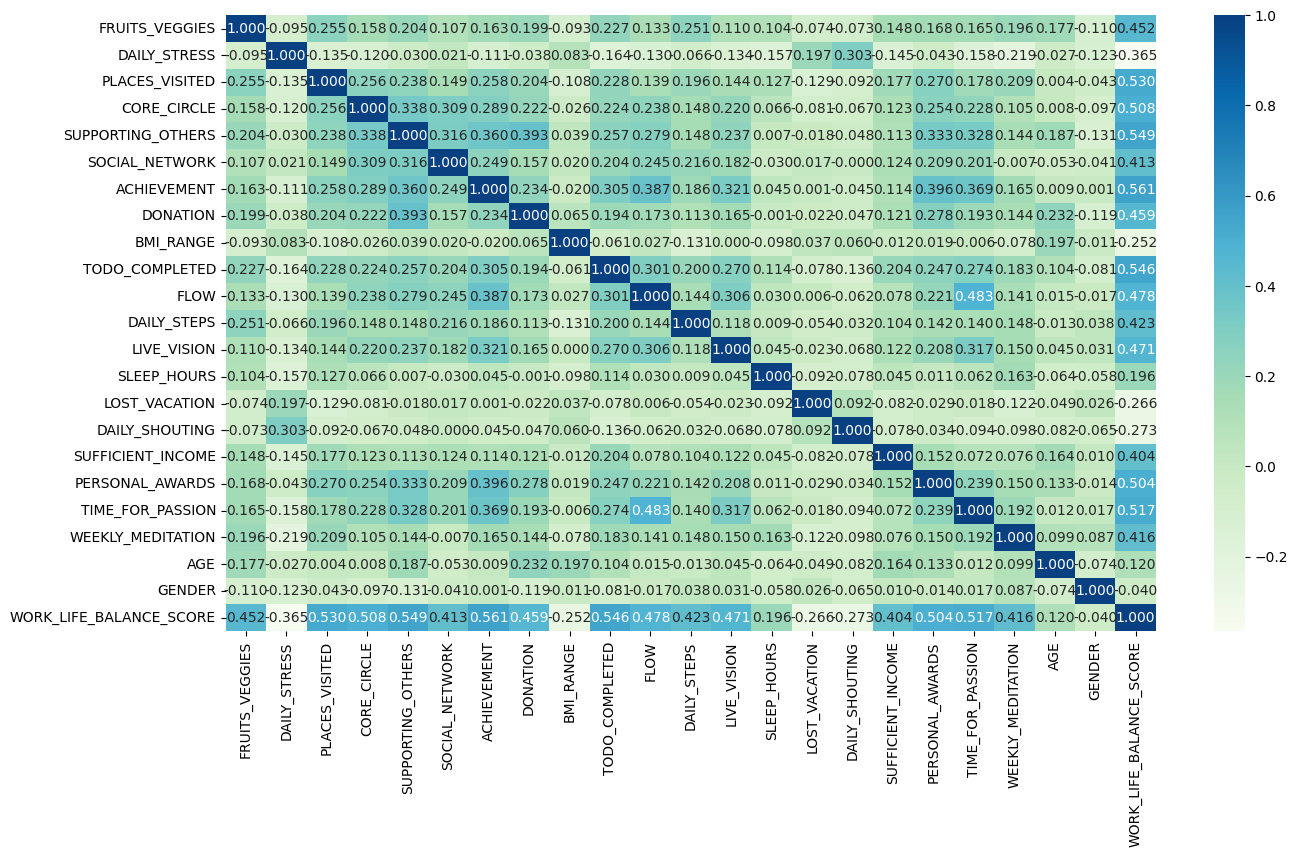

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "drive/My Drive/576_Project/data"
FILENAME = "Wellbeing_and_lifestyle_data_Kaggle.csv"

df = load_and_preprocess_data(GOOGLE_DRIVE_PATH_AFTER_MYDRIVE, FILENAME)
# print(df.head())


# correlation matrix
plt.figure(figsize=(15,8))
data = df.drop('Timestamp', axis=1)
# print(data)
sns.heatmap(data=data.corr(), annot=True, fmt='0.3f', cmap='GnBu');

In [ ]:
def partition_data(data: pd.DataFrame, partition_rules: Dict[str, Dict[str, Union[List[int], List[float]]]]) -> Dict[str, pd.DataFrame]:
    '''
    Inputs:
    - data: DataFrame, the full dataset.
    - partition_rules: Dictionary with keys as column names and values as dicts specifying:
        - "type": str, "value", "percentile", or "exact"
        - "bins": List of values or percentiles to partition by, or exact values for "exact" type.

    Example of partition_rules:
    {
        "AGE": {"type": "percentile", "bins": [0, 25, 50, 75, 100]},
        "GENDER": {"type": "value", "bins": [0, 1]},
        "CATEGORY": {"type": "exact", "bins": [1, 2, 3]}
    }

    Outputs:
    - Dictionary mapping partition names to DataFrames.
    '''
    def get_bins(column: pd.Series, partition_type: str, bins: List[Union[int, float]]) -> List[Union[int, float]]:
        if partition_type == "percentile":
            return [column.quantile(p / 100) for p in bins]
        elif partition_type == "value":
            return bins
        elif partition_type == "exact":
            return sorted(set(bins))  # Use exact values
        else:
            raise ValueError("Invalid partition type. Must be 'value', 'percentile', or 'exact'.")

    partitions = {}

    partition_ranges = {}
    for category, rules in partition_rules.items():
        column = data[category]
        partition_type = rules["type"]
        bins = rules["bins"]
        partition_ranges[category] = get_bins(column, partition_type, bins)

    categories = list(partition_rules.keys())

    for partition_combination in product(*[range(len(partition_ranges[cat])-1) if partition_rules[cat]["type"] != "exact" else range(len(partition_ranges[cat])) for cat in categories]):
        filter_conditions = []
        partition_name = []

        for idx, cat in enumerate(categories):
            if partition_rules[cat]["type"] == "exact":
                exact_val = partition_ranges[cat][partition_combination[idx]]
                filter_conditions.append(data[cat] == exact_val)
                partition_name.append(f"{cat}_Exact_{exact_val}")
            else:
                min_val = partition_ranges[cat][partition_combination[idx]]
                max_val = partition_ranges[cat][partition_combination[idx] + 1]

                if partition_combination[idx] < len(partition_ranges[cat]) - 2:
                    filter_conditions.append((data[cat] >= min_val) & (data[cat] < max_val))
                else:
                    filter_conditions.append((data[cat] >= min_val) & (data[cat] <= max_val))

                if partition_rules[cat]["type"] == "percentile":
                    partition_name.append(f"{cat}_Percentile_{partition_rules[cat]['bins'][partition_combination[idx]]}_to_{partition_rules[cat]['bins'][partition_combination[idx] + 1]}")
                else:
                    partition_name.append(f"{cat}_{min_val}_to_{max_val}")

        combined_filter = filter_conditions[0]
        for condition in filter_conditions[1:]:
            combined_filter &= condition

        partition_key = "_".join(partition_name)

        partition_df = data[combined_filter]

        partitions[partition_key] = partition_df

    total_partition_count = sum(len(partition) for partition in partitions.values())
    assert total_partition_count == len(data), "Partitioning error: Total count does not match the original DataFrame size."


    return partitions

In [ ]:
# Use this for understanding the ranges of each category in the dataset
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        min_val = df[column].min()
        max_val = df[column].max()
        print(f"{column}: Min = {min_val}, Max = {max_val}")
    else:
        unique_values = df[column].unique()
        print(f"{column}: Unique Values = {unique_values}")

Timestamp: Min = nan, Max = nan
FRUITS_VEGGIES: Min = 0, Max = 5
DAILY_STRESS: Min = 0.0, Max = 5.0
PLACES_VISITED: Min = 0, Max = 10
CORE_CIRCLE: Min = 0, Max = 10
SUPPORTING_OTHERS: Min = 0, Max = 10
SOCIAL_NETWORK: Min = 0, Max = 10
ACHIEVEMENT: Min = 0, Max = 10
DONATION: Min = 0, Max = 5
BMI_RANGE: Min = 1, Max = 2
TODO_COMPLETED: Min = 0, Max = 10
FLOW: Min = 0, Max = 10
DAILY_STEPS: Min = 1, Max = 10
LIVE_VISION: Min = 0, Max = 10
SLEEP_HOURS: Min = 1, Max = 10
LOST_VACATION: Min = 0, Max = 10
DAILY_SHOUTING: Min = 0, Max = 10
SUFFICIENT_INCOME: Min = 1, Max = 2
PERSONAL_AWARDS: Min = 0, Max = 10
TIME_FOR_PASSION: Min = 0, Max = 10
WEEKLY_MEDITATION: Min = 0, Max = 10
AGE: Min = 0, Max = 3
GENDER: Min = 0, Max = 1
WORK_LIFE_BALANCE_SCORE: Min = 480.0, Max = 820.2


In [ ]:
# Define the partition rules here
# Options for setting rules are:
#   - Values: define the boundaries between bins as values
#   - Percentile: define the boundaries between bins as percentiles
#   - Exact: define the exact values a category can take as a list

partition_rules = {
    "WORK_LIFE_BALANCE_SCORE": {"type": "percentile", "bins": [0, 10, 90, 100]},
    "GENDER": {"type": "exact", "bins": [0, 1]},  # Exact values for gender
    "BMI_RANGE": {"type": "exact", "bins": [1, 2]} # Exact values for BMI because there are only 2, not sure why
}

# Assume 'df' is your data DataFrame
partitions = partition_data(df, partition_rules)

# Example: print the first few rows of some partitions
for partition_name, partition_df in partitions.items():
    print(f"Partition: {partition_name}")
    print(f"{partition_name}: {len(partition_df)} items")
    # print(partition_df.head())

Partition: WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_1
WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_1: 315 items
Partition: WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_2
WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_2: 581 items
Partition: WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_1_BMI_RANGE_Exact_1
WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_1_BMI_RANGE_Exact_1: 263 items
Partition: WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_1_BMI_RANGE_Exact_2
WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_1_BMI_RANGE_Exact_2: 439 items
Partition: WORK_LIFE_BALANCE_SCORE_Percentile_10_to_90_GENDER_Exact_0_BMI_RANGE_Exact_1
WORK_LIFE_BALANCE_SCORE_Percentile_10_to_90_GENDER_Exact_0_BMI_RANGE_Exact_1: 4693 items
Partition: WORK_LIFE_BALANCE_SCORE_Percentile_10_to_90_GENDER_Exact_0_BMI_RANGE_Exact_2
WORK_LIFE_BALANCE_SCORE_Percentile_10_t

In [ ]:
## 3. Correlation Calculation
def calculate_correlation(data: pd.DataFrame, method: str = "pearson") -> pd.DataFrame:
    '''
    Inputs:
    - data: DataFrame for which to compute correlations.
    - method: str, correlation method ("pearson", "spearman", "kendall").

    Outputs:
    - DataFrame: correlation matrix.
    '''
    return data.corr(method=method)

In [ ]:
def is_significant_correlation(correlation_value, sample_size, alpha=0.05):
    """
    Runs a t-test to determine if a correlation value is significantly different from 0.

    Parameters:
    - correlation_value: The correlation coefficient to test.
    - sample_size: The number of samples in the partition.
    - alpha: Significance level (default is 0.05).

    Returns:
    - 1 if the correlation is significant, otherwise 0.
    """
    # Degrees of freedom for the t-test
    df = sample_size - 2

    # Calculate the t-statistic
    t_statistic = correlation_value * np.sqrt(df / (1 - correlation_value**2))

    # Calculate the two-tailed p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))

    # Return 1 if p-value is less than alpha, indicating significance
    return 1 if p_value < alpha else 0

def generate_significance_graph(correlation_matrix, sample_size):
    """
    Generates a matrix of 1s and 0s indicating whether each correlation
    in the correlation matrix is significant.

    Parameters:
    - correlation_matrix: The partition dataframe to analyze.

    Returns:
    - A DataFrame of 1s and 0s indicating significance.
    """
    # Create a matrix to store significance results, initially copying the correlation matrix
    significance_matrix = correlation_matrix.copy()

    # Iterate over the matrix to modify only off-diagonal elements
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            if i != j:  # Skip diagonal elements
                correlation_value = correlation_matrix.iloc[i, j]
                if not np.isnan(correlation_value):
                    significance_matrix.iloc[i, j] = is_significant_correlation(correlation_value, sample_size)
                else:
                    significance_matrix.iloc[i, j] = 0
            else:
                significance_matrix.iloc[i, j] = 0  # Set diagonal to 0

    return significance_matrix


In [ ]:
def visualize_graph(adj_matrix):
    """
    Visualizes a graph from an adjacency matrix.

    Parameters:
    - adj_matrix: A 2D dataframe where 1s represent edges and 0s represent no edges.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_pandas_adjacency(adj_matrix)

    # Draw the graph
    plt.figure(figsize=(15, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=8, font_weight='bold', edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()


Partition: WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_1
WORK_LIFE_BALANCE_SCORE_Percentile_0_to_10_GENDER_Exact_0_BMI_RANGE_Exact_1: 315 items


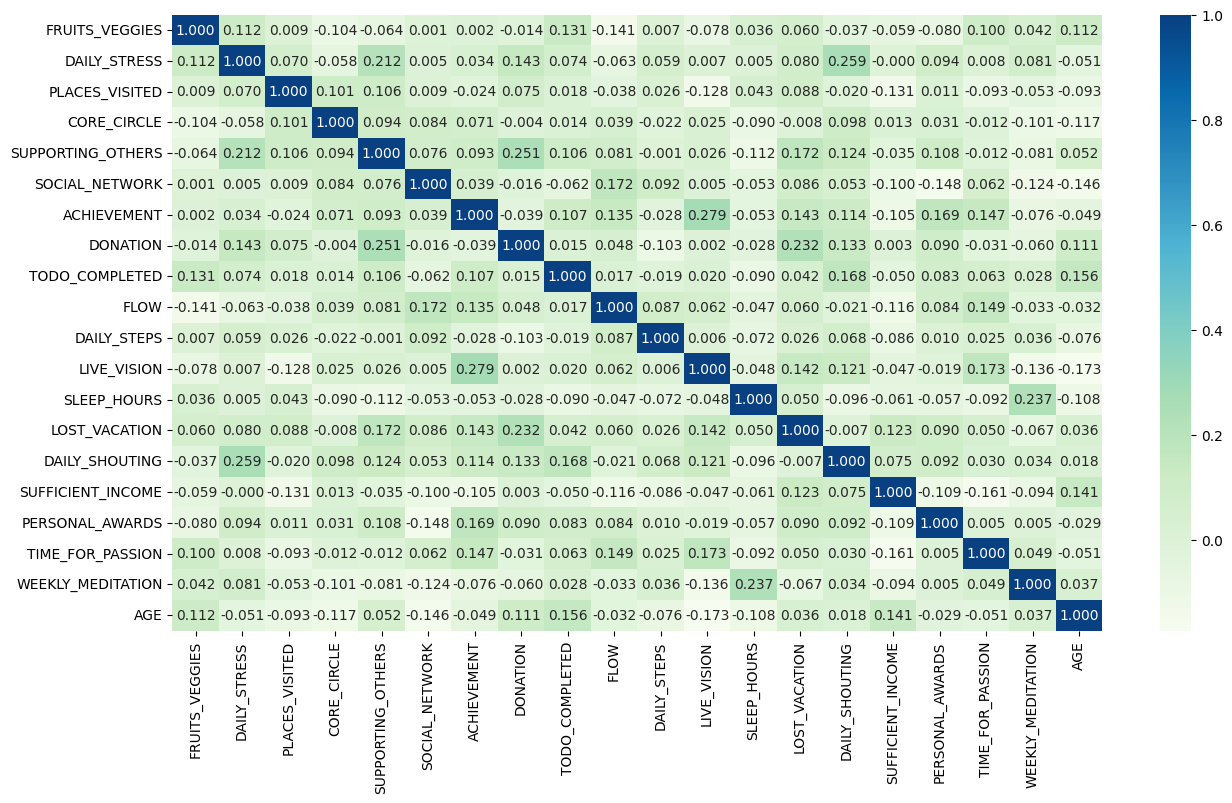

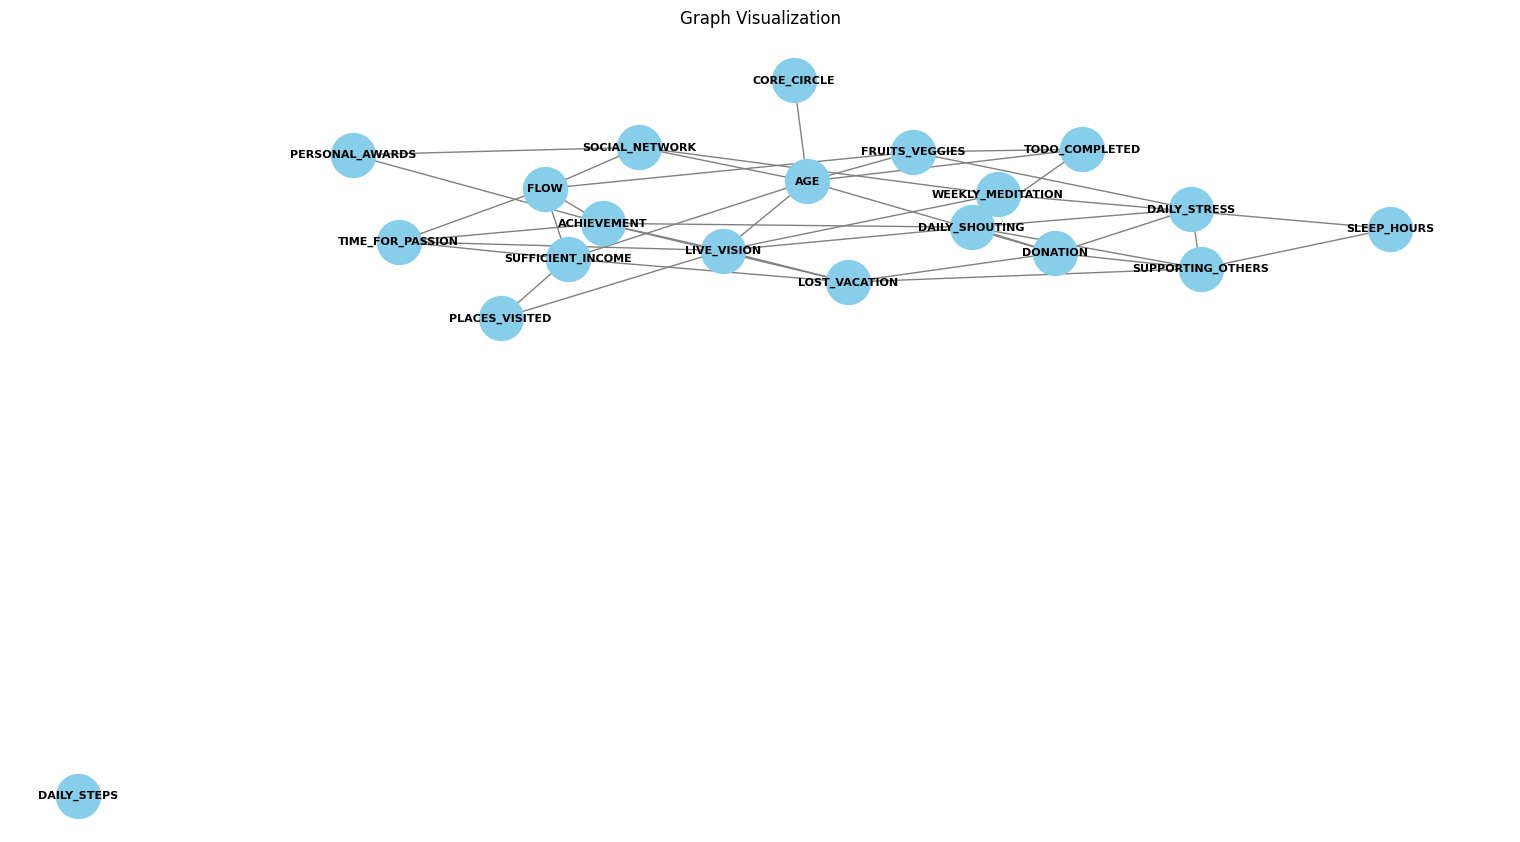

In [ ]:
for partition_name, partition_df in partitions.items():
    print(f"Partition: {partition_name}")
    print(f"{partition_name}: {len(partition_df)} items")

    partition_columns = list(partition_rules.keys())

    # Drop the columns used for partitioning from the data
    filtered_partition_df = partition_df.drop(columns=partition_columns, errors='ignore')
    filtered_partition_df = filtered_partition_df.drop('Timestamp', axis=1)

    sample_size = len(filtered_partition_df)
    # print(partition_df.head())
    plt.figure(figsize=(15,8))
    correlation_matrix = calculate_correlation(filtered_partition_df)
    sns.heatmap(data=correlation_matrix, annot=True, fmt='0.3f', cmap='GnBu')
    significance_graph = generate_significance_graph(correlation_matrix, sample_size)
    # print(significance_graph)
    visualize_graph(significance_graph)
    break


In [ ]:
## 6. Clustering Execution
def perform_clustering(significance_graph: pd.Dataframe, method: Callable, params: Dict[str, Any]) -> Dict[int, List[str]]:
    '''
    Inputs:
    - graph: Graph, correlation graph.
    - method: Callable, clustering method function.
    - params: Dict, parameters for the chosen clustering method.

    Outputs:
    - Dictionary mapping cluster IDs to lists of factor names.
    '''
    pass


In [ ]:
## 7. Graph Visualization
def visualize_graph(graph: Graph, clusters: Dict[int, List[str]], output_file: str) -> None:
    '''
    Inputs:
    - graph: Graph, correlation graph.
    - clusters: Dict, resulting clusters.
    - output_file: str, path for saving the visualization.

    Outputs:
    - None (saves the visualization to a file).
    '''
    pass

In [ ]:
## 8. Cluster Analysis and Comparison
def analyze_clusters(clusters: Dict[int, List[str]], partitions: Dict[str, DataFrame]) -> DataFrame:
    '''
    Inputs:
    - clusters: Dict, cluster results.
    - partitions: Dict, different subsets of the dataset.

    Outputs:
    - DataFrame summarizing key findings from clusters across partitions.
    '''
    pass

In [ ]:
## 9. Evaluation of Correlation Methods
def evaluate_correlation_methods(data: DataFrame, methods: List[str], partitions: Dict[str, DataFrame]) -> DataFrame:
    '''
    Inputs:
    - data: DataFrame, original dataset.
    - methods: List of correlation methods.
    - partitions: Dict of data partitions.

    Outputs:
    - DataFrame summarizing how correlation structures vary across methods.
    '''
    pass

In [ ]:
def initialize_communities(graph):
  return {node: node for node in graph.nodes()}


def calculate_modularity(graph, communities):
    m = graph.size(weight='weight')
    q = 0.0
    for community in communities.values():
        in_degree = 0.0
        total_degree = 0.0
        for node in community:
            in_degree += sum(graph[node][neighbor].get('weight', 1) for neighbor in community if neighbor in graph[node])
            total_degree += sum(graph[node][neighbor].get('weight', 1) for neighbor in graph[node])
        q += (in_degree / (2 * m)) - (total_degree / (2 * m)) ** 2
    return q

In [ ]:
## 10. Evaluation of Clustering Methods
def louvain_clustering(graph: Graph, params: Dict[str, Any], weighted=False) -> Dict[int, List[str]]:
  if weighted:
    pass
  else:
    pass
def kmeans_clustering(graph: Graph, params: Dict[str, Any]) -> Dict[int, List[str]]:
  pass
def gn_clustering(graph: Graph, params: Dict[str, Any]) -> Dict[int, List[str]]:
  pass

def evaluate_clustering_methods(graph: Graph, methods: List[str], params: Dict[str, Dict[str, Any]]) -> DataFrame:
    '''
    Inputs:
    - graph: Graph, correlation graph.
    - methods: List of clustering methods to test.
    - params: Dict, parameters for each clustering method.

    Outputs:
    - DataFrame comparing performance and output of clustering methods.
    '''
    # louvain & GN & k-means
    louvain_result = louvain_clustering(graph, params["louvain"])
    gn_result = gn_clustering(graph, params["GN"])
    k_means_result = kmeans_clustering(graph, params["k-means"])
    pass

NameError: name 'Graph' is not defined

In [ ]:
# Pseudocode for Lifestyle Factors Analysis Project

# Program Inputs:
# - clustering_methods: List of clustering methods to analyze (e.g., ["louvain", "k-means"])
# - thresholds: Dictionary of correlation thresholds to determine significant connections (e.g., {"pearson": 0.3, "spearman": 0.4})
# - partition_descriptions: Descriptions of how to partition data (e.g., {"age": ["<30", "30-50", ">50"], "work-life_balance": ["low", "medium", "high"]})

# Step 1: Load and Preprocess Data
# - Read dataset from specified file path
# - Clean and preprocess the data as needed (e.g., handling missing values, normalizing)
# - Store the cleaned data in a suitable data structure

# Step 2: Partition the Data
# - Use the partition_descriptions to divide the dataset into subsets
# - Each subset (partition) will represent a group based on factors (e.g., age groups, work-life balance tiers)

# Step 3: Initialize Storage for Results
# - Create data structures to store correlation graphs and clustering results for each partition and method combination

# Step 4: Calculate Correlation Graphs for Each Partition
# - Loop through each partition
#   - For each partition, loop through specified correlation methods
#     - Calculate correlation matrix using the selected method (e.g., Pearson, Spearman)
#     - Generate a correlation graph based on the calculated matrix and apply the threshold to filter out weak correlations
#     - Store the resulting graph for later use

# Step 5: Filter Graphs Based on Significance
# - Apply statistical tests (e.g., t-test) on edges of each graph to determine which correlations are statistically significant
# - Update the graph to keep only edges that meet the significance criteria based on the threshold values

# Step 6: Run Clustering Algorithms on Each Graph
# - For each graph (from Step 5), loop through the list of clustering methods
#   - Dynamically select the clustering method based on input parameters
#   - Run the selected clustering algorithm on the graph to detect clusters
#   - Store the clusters for future analysis

# Step 7: Analyze and Compare Clusters Across Partitions
# - Use the clustering results from different partitions to identify patterns
# - Compare clusters to detect similarities and differences between various groups
# - Summarize findings for each partition, noting key insights and potential patterns

# Step 8: Evaluate the Effectiveness of Different Clustering and Correlation Methods
# - Assess the impact of different correlation methods by comparing how they affect the graph structure and clustering results
# - Evaluate clustering methods by comparing the quality of clusters produced
# - Determine which methods are most effective based on performance and suitability to the data

# Step 9: Visualization (Optional)
# - Optionally, create visualizations of the correlation graphs
#   - Highlight clusters in the graph for easy interpretation
#   - Save the visualizations to files for presentation or further analysis

# Step 10: Output Results
# - Print or save the final analysis summarizing key findings from the clusters
# - Print or save the evaluation of correlation and clustering methods, indicating which methods provided the most useful insights
